In [1]:
%run /Users/hhg/Research/kinematic_lensing/code/BinnedFit/GaussFit_spec2D.py
%run /Users/hhg/Research/kinematic_lensing/code/BinnedFit/ChainTool.py

%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import numpy as np

dir_tfCube: /Users/hhg/Research/kinematic_lensing/repo/KLens


In [2]:
import sys
sys.path.append("/Users/hhg/Research/kinematic_lensing/repo/kl_measurement/scripts/")

from generate_TFcube import get_TFcube_pars, get_data_TFcube

In [4]:
update_TF, _ = get_TFcube_pars()
update_TF['g1'] = 0.05
update_TF['sini'] = 0.8 
update_TF['vcirc'] = 200. 

update_TF['n_knots'] = 10.
update_TF['knot_fraction'] = 0.0
update_TF['throughput'] = 0.78
update_TF['slitWidth'] = 0.02
update_TF['psfFWHM'] = 0.5
update_TF['pixScale'] = 0.032

update_TF['redshift'] = 0.2
update_TF['Resolution'] = 5000.
update_TF['nm_per_pixel'] = 0.025
update_TF['expTime'] = 10000.0
update_TF['linelist']['flux'][update_TF['linelist']['species'] == 'Halpha'] = 6.0e-24
update_TF['lambda_min'] = (1 + update_TF['redshift']) * update_TF['linelist']['lambda'][update_TF['linelist']['species'] == 'Halpha'] - 2
update_TF['lambda_max'] = (1 + update_TF['redshift']) * update_TF['linelist']['lambda'][update_TF['linelist']['species'] == 'Halpha'] + 2
update_TF['norm'] = 1e-26

update_TF['add_continuum'] = False

TF_pars, meta_parameters = get_TFcube_pars(update_TF)
data, noise, obslambda = get_data_TFcube(TF_pars, meta_parameters, return_lambda=True)

returning:
lambda, observation, model, sky (the last three are (npix, npix, nspax) datacubes)


In [5]:
# make data_info from Prangal's data output

data_info = {}
data_info['ModelCube'] = None
data_info['ObsCube'] = None
data_info['image'] = data['image']
data_info['image_variance'] = noise['image']

if len(TF_pars['slitAngles']) == 1:
    data_info['data'] = data['spectra'][0]
else:
    data_info['data_list'] = data['spectra']
    
data_info['grid_lambda'] = obslambda

extent =  TF_pars['image_size'] * TF_pars['pixScale']
subGridPixScale = extent*1./TF_pars['ngrid']

data_info['grid_pos']  = np.arange(-extent/2., extent/2., subGridPixScale)
data_info['grid_Image'] = np.arange(-extent/2., extent/2., TF_pars['pixScale'])
data_info['par_fid']   = TF_pars
data_info['lambda_emit'] = 656.461 # Halpha [nm]

In [6]:
TF_pars

{'g1': 0.05,
 'g2': 0.0,
 'sini': 0.8,
 'diskFrac': 1.0,
 'n_knots': 10.0,
 'knot_fraction': 0.0,
 'aspect': 0.2,
 'vcirc': 200.0,
 'sigma_intr': 0.01,
 'redshift': 0.2,
 'half_light_radius': 0.5,
 'vscale': 0.5,
 'r_0': 0.0,
 'V_0': 0.0,
 'linelist': array([('OIIa', 372.7092, 2.e-25), ('OIIb', 372.9875, 2.e-25),
        ('OIIIa', 496.0295, 2.e-25), ('OIIIb', 500.824 , 2.e-25),
        ('Halpha', 656.461 , 6.e-24)],
       dtype=[('species', '<U16'), ('lambda', '<f8'), ('flux', '<f8')]),
 'norm': 1e-26,
 'abs_magnitude': None,
 'image_size': 128,
 'ngrid': 256,
 'psfFWHM': 0.5,
 'psf_g1': 0.0,
 'psf_g2': 0.0,
 'area': 785000.0,
 'pixScale': 0.032,
 'Resolution': 5000.0,
 'lambda_min': array([785.7532]),
 'lambda_max': array([789.7532]),
 'nm_per_pixel': 0.025,
 'gain': 1.0,
 'read_noise': 3.0,
 'throughput': 0.78,
 'expTime': 10000.0,
 'type_of_observation': 'slit',
 'fiber_size': 1.0,
 'fiber_offsets': [[0.0, 0.0],
  [1.0, 0.0],
  [-1.0, 0.0],
  [0.0, 1.0],
  [1.0, 1.0]],
 'slitAngles

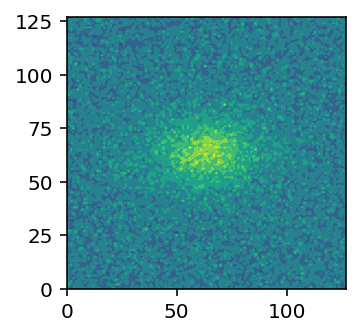

In [7]:
# check image
fig, ax = plt.subplots(1,1, figsize=(2.5,2.5))
ax.contourf(data_info['image'])

# Image 

In [9]:
%run /Users/hhg/Research/kinematic_lensing/code/BinnedFit/ImageFit.py

In [10]:
ImageFit = ImageFit(data_info=data_info)

In [11]:
# check : data model consistency 
model_image = ImageFit.model_image(e_obs=1, half_light_radius=0.5)

print("data signal", ImageFit.image[63,63])
print("model signal", model_image[63,63])

data signal 0.0010825938
model signal 0.00074318505


In [12]:
chainImage_info = ImageFit.run_MCMC(Nwalker=50, Nsteps=1000)

100%|██████████| 1000/1000 [01:28<00:00, 11.33it/s]

Total MCMC time (mins): 1.4730143706003824


In [13]:
Chain_Image = ChainTool(chainImage_info, Nburn=30000, Nend=50000)

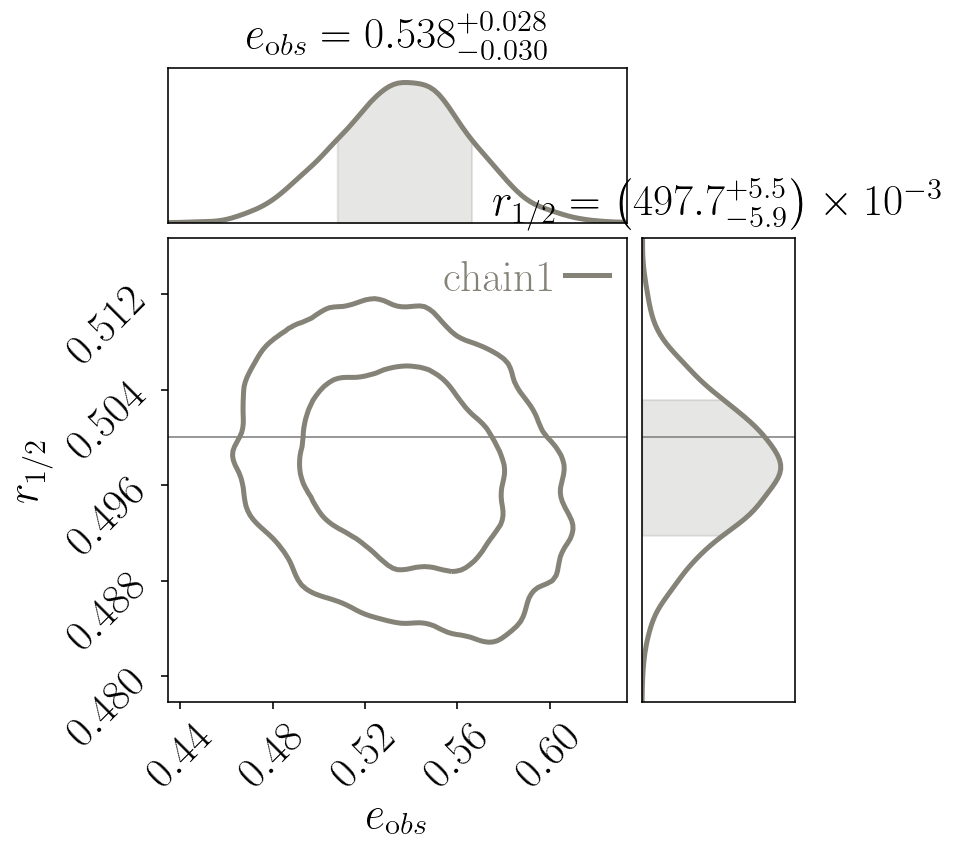

In [14]:
Nchains = 1
colors = [gray, lightblue, red, yellow, blue, yellowgreen, green, green, black]
lines = ["-", '--', "--", "-.", '-', ":", "--", ':']

statistics="max"

select_par_key = ['e_obs','half_light_radius']

parID1,parName1,par_x1 = Chain_Image.select_par_info(select_par_key)

c = ChainConsumer()
c.add_chain(Chain_Image.chain[:, parID1], parameters=parName1 ,name="$\mathrm{chain1}$")


c.configure(linewidths=2.5,sigmas=np.array([0,1,2]),bins=0.5,sigma2d=False,label_font_size=22,tick_font_size=22
            ,colors=colors
            ,shade=[False]*Nchains
            ,statistics=statistics,summary=True
            ,linestyles=lines
            ,shade_gradient=[0]*Nchains
            ,bar_shade=[True]*Nchains)


c.configure_truth(color="gray",lw=1,ls="-",alpha=0.8, zorder=-1)
fig = c.plotter.plot(legend=True, truth=[None,0.5]) #, truth=par_x1

fig.subplots_adjust(left=0.12, right=0.99, bottom=0.11, top=0.99)

fig.set_size_inches(2 + fig.get_size_inches())
fig.savefig("fig1.pdf", transparent=True)

In [15]:
bestfit_e_obs = Chain_Image.par_bestfit(select_par_key=['e_obs'], statistics='max')['e_obs'][1]
bestfit_e_obs

0.5349873202025898

# 2D spectrum

In [14]:
%run /Users/hhg/Research/kinematic_lensing/code/BinnedFit/RotationCurveFit.py

In [15]:
# init Fit tool
RotFit = RotationCurveFit(data_info, active_par_key = ['vscale','vcirc','sini'], e_obs=bestfit_e_obs)

time cost in gaussFit_spec2D: 0.396665096282959 (secs)


In [16]:
# find fitting parameter using optimizer
params_rot = RotFit.optFit_rotation_curve(RotFit.gaussfit_peakLambda)
params_rot

{'vscale': 0.49871697621885414,
 'r_0': -9.999999999999999e-09,
 'vcirc': 200.0513511251338,
 'v_0': -8.160874620692622e-22,
 'redshift': 0.19999999999999998,
 'sini': 0.8000329922916445}

In [17]:
# find fitting parameters using MCMC (get error bars as well)
chain_info = RotFit.run_MCMC(Nwalker=100, Nsteps=3000)

/Users/hhg/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 3000/3000 [00:23<00:00, 127.15it/s]

Total MCMC time (mins): 0.39348936478296914


In [18]:
%run /Users/hhg/Research/kinematic_lensing/code/BinnedFit/ChainTool.py
Chain = ChainTool(chain_info, Nburn=150000, Nend=300000)

In [19]:
Chain.chain.shape

(150000, 6)

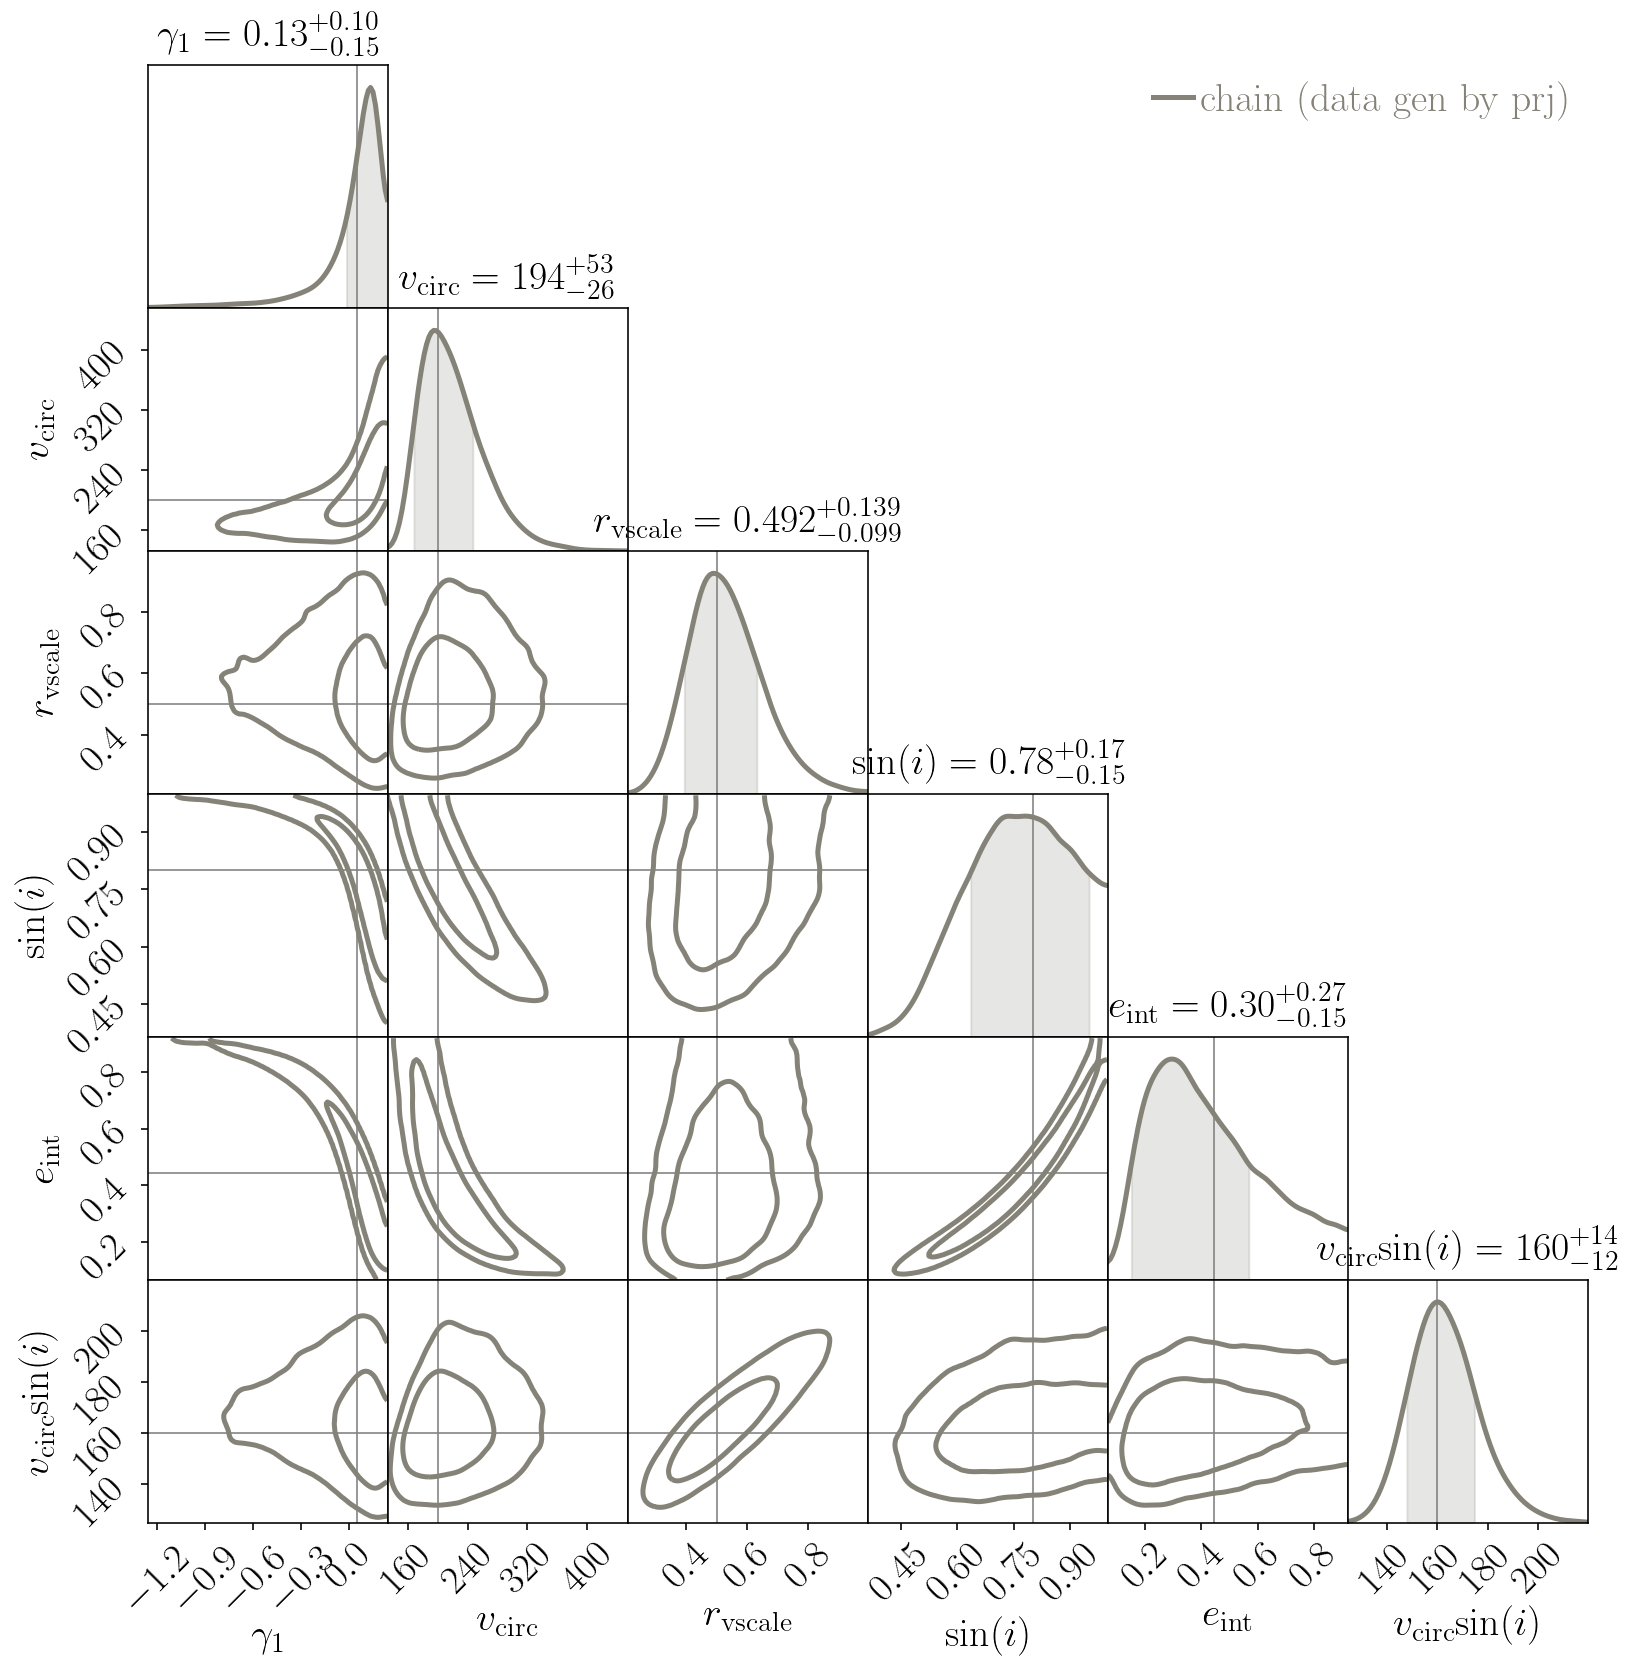

In [20]:
Nchains = 1
colors = [gray, lightblue, red, yellow, blue, yellowgreen, green, green, black]
lines = ["-", '--', "--", "-.", '-', ":", "--", ':']

statistics="max"

select_par_key = ['g1','vcirc','vscale','sini','e_int','vsini']

parID1,parName1,par_x1 = Chain.select_par_info(select_par_key)

c = ChainConsumer()
c.add_chain(Chain.chain[:, parID1]       , parameters=parName1 ,name="$\mathrm{chain\ (data\ gen\ by\ prj)}$")

c.configure(linewidths=2.5,sigmas=np.array([0,1,2]),bins=0.5,sigma2d=False,label_font_size=20,tick_font_size=20
            ,colors=colors
            ,shade=[False]*Nchains
            ,statistics=statistics,summary=True
            ,linestyles=lines
            ,shade_gradient=[0]*Nchains
            ,bar_shade=[True]*Nchains)


c.configure_truth(color="gray",lw=1,ls="-",alpha=0.8, zorder=-1)
fig = c.plotter.plot(legend=True, truth=par_x1)

fig.subplots_adjust(left=0.12, right=0.99, bottom=0.11, top=0.99)

fig.set_size_inches(2.5 + fig.get_size_inches())
fig.savefig("fig1.pdf", transparent=True)

# ---- END ----

In [21]:
import emcee
import numpy as np

def log_prior(params):
    return -0.5 * np.sum(params**2)

def log_like(params):
    return -0.5 * np.sum((params / 0.1)**2)

def log_prob(params):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf, -np.inf
    ll = log_like(params)
    if not np.isfinite(ll):
        return lp, -np.inf
    return lp + ll, lp

coords = np.random.randn(32, 3)
nwalkers, ndim = coords.shape
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob)
sampler.run_mcmc(coords, 100)

log_prior_samps = sampler.get_blobs()
flat_log_prior_samps = sampler.get_blobs(flat=True)

print(log_prior_samps.shape)  # (100, 32)
print(flat_log_prior_samps.shape)  # (3200,)

(100, 32)
(3200,)


In [22]:
log_prior_samps.shape

(100, 32)

In [23]:
sampler.get_last_sample().coords

array([[ 0.1435311 , -0.05266277, -0.03852604],
       [-0.05700692,  0.09402132, -0.11293025],
       [-0.12421615, -0.00215865,  0.17842402],
       [-0.09952241, -0.11566001,  0.03370004],
       [ 0.04843294, -0.10683683, -0.01305616],
       [ 0.1241705 ,  0.1126215 , -0.1412872 ],
       [ 0.04421555,  0.16852123,  0.04375411],
       [ 0.12094562,  0.02650241,  0.06209085],
       [-0.02593073,  0.04042154, -0.17775765],
       [ 0.04678073,  0.0702089 ,  0.01276789],
       [ 0.10329455, -0.03393108, -0.12369396],
       [-0.1945233 ,  0.11284926, -0.03215088],
       [-0.13465889,  0.03826869,  0.06753894],
       [-0.04400496, -0.21438885, -0.07728101],
       [-0.0279958 , -0.08780473, -0.09622086],
       [-0.05556077, -0.03538695,  0.09214501],
       [-0.02494104,  0.02965348, -0.15968672],
       [-0.06859806, -0.0351618 , -0.09770232],
       [-0.11428889,  0.15233781,  0.1688022 ],
       [ 0.15125886,  0.0379655 , -0.13838828],
       [-0.20074553, -0.11235101, -0.042